# NNMF with cross-validated number of components

INFO:


TODO:
- plot repeated nnmf_cv results and find cutoff at CI95

In [1]:
# Library/module setup
from cv import * # NNMF cross-validation functions

import scipy.io as sio

import matplotlib.pyplot as plt # plotting lib

import multiprocessing # parallel computing
import time # timing computations
import datetime

%matplotlib inline
%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.4/dist-packages/matplotlib/cbook.py:128: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the matplotlib toolkit finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
# Load PSTH data (.mat file)
orig_data = sio.loadmat('../data/nnmf_best.mat')
sio.whosmat('../data/nnmf_best.mat')

[('A', (641, 25), 'double'),
 ('D_res', (100, 1), 'double'),
 ('X', (641, 815), 'double'),
 ('Y', (25, 815), 'double'),
 ('k_best', (1, 1), 'double'),
 ('psth', (1, 1), 'struct')]

In [3]:
# Extract PSTH data
data = orig_data['psth']['psth'][0,0] # PSTH array is in nnmf_best.psth.psth
print('data: firing rate PSTH of %i cells x %i tPoints' % data.shape)

data: firing rate PSTH of 815 cells x 641 tPoints


# Fit NNMF model

In [4]:
# Parameters
ranks = [[x] for x in range(31,40+1)] # range of components to test
repetitions = range(0,10) # number of repetitions; given as range to control rep_ID while running code in chunks
iterator = [(i[0],j+1) for (i,j) in itertools.product(ranks, repetitions)]

In [5]:
iterator

[(31, 1),
 (31, 2),
 (31, 3),
 (31, 4),
 (31, 5),
 (31, 6),
 (31, 7),
 (31, 8),
 (31, 9),
 (31, 10),
 (32, 1),
 (32, 2),
 (32, 3),
 (32, 4),
 (32, 5),
 (32, 6),
 (32, 7),
 (32, 8),
 (32, 9),
 (32, 10),
 (33, 1),
 (33, 2),
 (33, 3),
 (33, 4),
 (33, 5),
 (33, 6),
 (33, 7),
 (33, 8),
 (33, 9),
 (33, 10),
 (34, 1),
 (34, 2),
 (34, 3),
 (34, 4),
 (34, 5),
 (34, 6),
 (34, 7),
 (34, 8),
 (34, 9),
 (34, 10),
 (35, 1),
 (35, 2),
 (35, 3),
 (35, 4),
 (35, 5),
 (35, 6),
 (35, 7),
 (35, 8),
 (35, 9),
 (35, 10),
 (36, 1),
 (36, 2),
 (36, 3),
 (36, 4),
 (36, 5),
 (36, 6),
 (36, 7),
 (36, 8),
 (36, 9),
 (36, 10),
 (37, 1),
 (37, 2),
 (37, 3),
 (37, 4),
 (37, 5),
 (37, 6),
 (37, 7),
 (37, 8),
 (37, 9),
 (37, 10),
 (38, 1),
 (38, 2),
 (38, 3),
 (38, 4),
 (38, 5),
 (38, 6),
 (38, 7),
 (38, 8),
 (38, 9),
 (38, 10),
 (39, 1),
 (39, 2),
 (39, 3),
 (39, 4),
 (39, 5),
 (39, 6),
 (39, 7),
 (39, 8),
 (39, 9),
 (39, 10),
 (40, 1),
 (40, 2),
 (40, 3),
 (40, 4),
 (40, 5),
 (40, 6),
 (40, 7),
 (40, 8),
 (40, 9),
 

In [5]:
# Progress bar
# from tqdm import tqdm
# pbar = tqdm(total=len(iterator))

In [6]:
def nnmf_parallel(rank, repetition, data=data):
    
    ## Set random number generator seed 
    # This is necessary to get different results from multiprocessing.
    # One method is to set the seed to current time. Here, we convert sub-second values to int, because 
    # otherwise, parallel processes starting within the same second will have the same seed.
#     seed = int(str(time.time()).split(".")[1])
    # Another method to easily set reproducible seeds per rank and repetition is this one:
    seed = int(''.join((str(rank), str(repetition)))) # set reproducible seed
    np.random.seed(seed=seed)    

    print('  Fitting model:   rank: %i, repetition: %i, seed: %i ...' % (rank, repetition, seed))
    train_err, test_err = cv_pca(data, rank, M=None, p_holdout=0.3, nonneg=True)[2:]
    
#     pbar.update(1)
    
    return (rank, train_err, test_err, seed)

In [ ]:
t = time.time()

train_err, test_err = [], [] # initialize vars


# Fit NNMF model (parallel implementation)
n_processes = multiprocessing.cpu_count()-1 # use max number of kernels (spare one)
print('Fitting model for ranks %i-%i with %i repetition(s).' \
      % (np.min(ranks), np.max(ranks), repetitions[-1]-repetitions[0]+1))
print('Running parallelization with %i processes.' % n_processes)
with multiprocessing.Pool(processes=n_processes) as pool:
    temp = pool.starmap(nnmf_parallel, iterator)

train_err = [(i[0], i[1]) for i in temp]
test_err = [(i[0], i[2]) for i in temp]
seeds = [(i[3]) for i in temp]

dur = round(time.time() - t)
print('DONE! Execution time: %s (h:min:sec).' % str(datetime.timedelta(seconds=dur)))

Fitting model for ranks 31-40 with 10 repetition(s).
Running parallelization with 23 processes.
  Fitting model:   rank: 31, repetition: 1, seed: 311 ...
  Fitting model:   rank: 31, repetition: 9, seed: 319 ...
  Fitting model:   rank: 31, repetition: 5, seed: 315 ...
  Fitting model:   rank: 31, repetition: 3, seed: 313 ...
  Fitting model:   rank: 31, repetition: 7, seed: 317 ...
  Fitting model:   rank: 32, repetition: 1, seed: 321 ...
  Fitting model:   rank: 32, repetition: 3, seed: 323 ...
  Fitting model:   rank: 32, repetition: 5, seed: 325 ...
  Fitting model:   rank: 32, repetition: 9, seed: 329 ...
  Fitting model:   rank: 32, repetition: 7, seed: 327 ...
  Fitting model:   rank: 33, repetition: 1, seed: 331 ...
  Fitting model:   rank: 33, repetition: 5, seed: 335 ...
  Fitting model:   rank: 33, repetition: 3, seed: 333 ...
  Fitting model:   rank: 33, repetition: 9, seed: 339 ...
  Fitting model:   rank: 34, repetition: 1, seed: 341 ...
  Fitting model:   rank: 34, repet

In [ ]:
# Save results
do_save = True

if do_save:
    nnmf_cv_err_per_comp = {'train_err': train_err, 'test_err': test_err, 'seeds': seeds}
    np.save('../data/nnmf_cv_err_per_comp_31-40_1-10.npy', nnmf_cv_err_per_comp)

In [ ]:
# Save execution time log
time_log = {'dur_s': dur, 'dur_hms': str(datetime.timedelta(seconds=dur))}
np.save('../data/time_log_31-40_1-10.npy', time_log)

In [33]:
# Load if it doesn't exist in workspace
if not ('nnmf_cv_err_per_comp' in locals() or 'nnmf_cv_err_per_comp' in globals()):
    nnmf_cv_err_per_comp = np.load('../data/nnmf_cv_err_per_comp_1-10_1-10.npy').item()
    test_err = nnmf_cv_err_per_comp['test_err']
    train_err = nnmf_cv_err_per_comp['train_err']

In [21]:
# Find optimal rank / number of components
opt_rank = test_err[np.argmin([x[1] for x in test_err])]
print('Optimal number of components: %i \t MSE: %f' % (opt_rank[0], opt_rank[1]))

Optimal number of components: 10 	 MSE: 0.012051


# Plot

In [22]:
def defaultPlotPars():
    """Defines default plot parameters by changing rcParams.
    TODO: 
        - See if need to output other plot params that cannot be changed in rcParams. 
        - Allow for dict input of parameters.
    """
    from pylab import rcParams as rc

    plot_par = {'font.size': 13.0,
           'axes.linewidth': 1,
           'axes.labelsize': 'large',
           'axes.titlesize': 'large',
           'xtick.labelsize': 'medium',
           'ytick.labelsize': 'medium',
           }
    rc.update(plot_par)
    
    return rc, plot_par

In [23]:
rc, plot_par = defaultPlotPars()

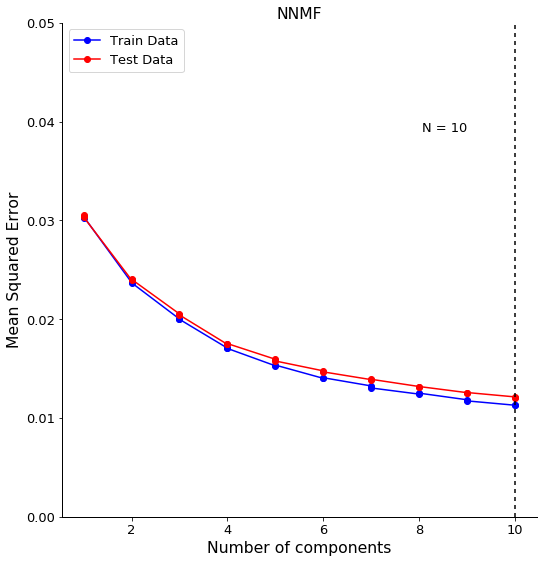

In [28]:
## Plot cross-validated train vs test errors

# Pars
save_fig = False

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(*list(zip(*train_err)), linestyle='-', marker='o', color='b', label='Train Data')
ax.plot(*list(zip(*test_err)), linestyle='-', marker='o', color='r', label='Test Data')
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Number of components')
ax.set_title('NNMF')
ax.axvline(opt_rank[0], color='k', dashes=[2,2])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
fig.tight_layout()
ax.set_ylim((0,0.05))
ax.text(opt_rank[0]-1, ax.get_ylim()[1]-0.01, 'N = %i' % opt_rank[0],
        verticalalignment='top', horizontalalignment='right')

if save_fig:
    fig.savefig('../figures/nnmf_crossval_curves.pdf')
    fig.savefig('../figures/nnmf_crossval_curves.png')

In [58]:
# Get ratio of cross-validated train vs test errors
a = [i[1] for i in test_err]
b = [i[1] for i in train_err]

ratio = [i / j for i,j in zip(a,b)]

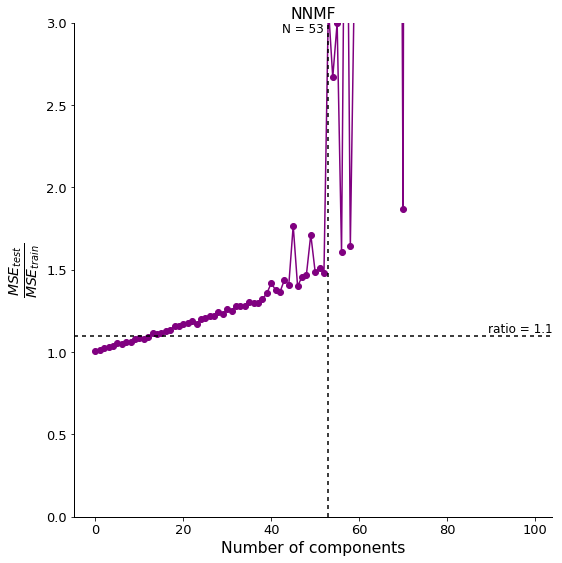

In [207]:
## Plot ratio of cross-validated train vs test errors

# Pars
ratio_cut = 1.1
ylim_cut = 3
save_fig = False

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(ratio, 'o-', color='purple') # label='ratio(test_err / train_err)')
# ax.set_ylabel('$MSE_{test}$ / $MSE_{train}$')
ax.set_ylabel('$\\frac{MSE_{test}}{MSE_{train}}$', Fontsize=20)
ax.set_xlabel('Number of components')
ax.set_title('NNMF')
ax.set_ylim(0, ylim_cut)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Vertical line at optimal number of ranks
ax.axvline(opt_rank[0], color='k', dashes=[2,2])
ax.text(opt_rank[0]-1, ax.get_ylim()[1], 'N = %i' % opt_rank[0], Fontsize=12,
        verticalalignment='top', horizontalalignment='right')
# Horizontal line for ratio cut-off
ax.axhline(ratio_cut, color='k', dashes=[2,2])
ax.text(ax.get_xlim()[1], ratio_cut, 'ratio = %.1f'%ratio_cut,
        Fontsize=12, verticalalignment='bottom', horizontalalignment='right')

ax.legend()
fig.tight_layout()

if save_fig:
    fig.savefig('../figures/nnmf_crossval_curves_ratio.pdf')
    fig.savefig('../figures/nnmf_crossval_curves_ratio.png')

# Fit model w desired number of components

In [223]:
data.shape

(815, 641)

In [249]:
# Define rank / number of components
rank = 30 # opt_rank[0]

# Fit model with optimal number of components
print('Fitting model with %i components...' %rank)
U, Vt, tr_err, te_err = cv_pca(data, rank, nonneg=True)

print('U: Cells and their component weights \t [n_cells x n_components] =', U.shape)
print('Vt: Components and their time weights \t [n_componetns x n_tPoints] =', Vt.shape)

Fitting model with 30 components...
U: Cells and their component weights 	 [n_cells x n_components] = (815, 30)
Vt: Components and their time weights 	 [n_componetns x n_tPoints] = (30, 641)


In [250]:
# Save components for plotting

do_save = True

if do_save:
    # Save as .mat struct to use Miro's plotting scripts
    print('Saving to: '+'../data/nnmf_cv_comps.mat')
    sio.savemat('../data/nnmf_cv_comps.mat',
                {'U': U,
                 'Vt': Vt,
                 'tr_err': tr_err,
                 'te_err': te_err,
                })

Saving to: ../data/nnmf_cv_comps.mat


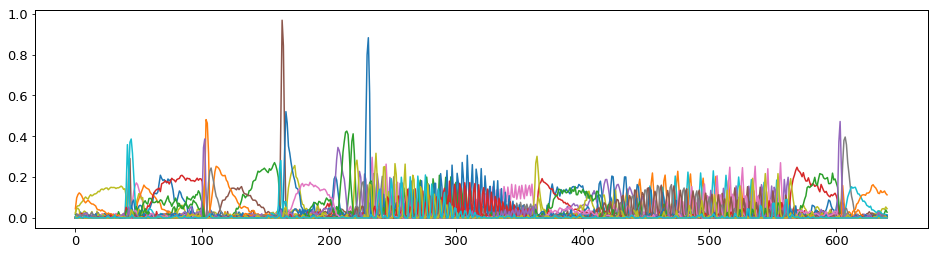

In [248]:
# Plot components
fig, ax = plt.subplots(1, 1, figsize=(16,4))

ax.plot(Vt.T)
plt.show()


# TESTS

In [2]:
# Do dry run with artificial data generated by plot_nmf()
plot_nmf()

Fitting model with rank 1/7 ...
Fitting model with rank 2/7 ...
Fitting model with rank 3/7 ...
Fitting model with rank 4/7 ...
Fitting model with rank 5/7 ...
Fitting model with rank 6/7 ...
Fitting model with rank 7/7 ...
DONE.


In [24]:
# Parameters
# N, R = 150, 4
# noise = .8
repetitions = 2
ranks = np.arange(1, 3)

In [5]:
# Initialize problem
# U = np.random.rand(N, R)
# Vt = np.random.rand(R, N)
# data = np.dot(U, Vt) + noise*np.random.rand(N, N)
# train_err, test_err = [], []

In [25]:
# Fit NNMF models w various k components

train_err, test_err = [], [] # initialize problem

t = time.time() # get execution time
for rnk, _ in itertools.product(ranks, range(repetitions)):
    print('Fitting model with rank %i/%i ...' % (rnk, ranks[-1]))
    tr, te = cv_pca(data, rnk, nonneg=True)[2:]
    train_err.append((rnk, tr))
    test_err.append((rnk, te))
    
print('DONE! Execution time: %i s.' % round(time.time() - t))

Fitting model with rank 1/2 ...
Fitting model with rank 1/2 ...
Fitting model with rank 2/2 ...
Fitting model with rank 2/2 ...
DONE! Execution time: 91 s.
